# In-Core Computation of Geometric Centralities with HyperBall: A Hundred Billion Nodes and Beyond

We have selected the article from P.Boldi and S.Vigna <a href="https://arxiv.org/pdf/1308.2144v2.pdf"> [Link]</a>. We have used a dataset from Snap website <a href="https://snap.stanford.edu/data/p2p-Gnutella08.html"> [Link]</a> with 6301 edges and 20777 nodes.

# Instructions

To test our algorithms, you first need to download the data used for this work and unzip it in a folder called "Data" that is placed at the same position as this notebook. Otherwise, you can change the variable <code>dir_path</code> in the case below [Import data](#Import-data) to make it convinient for your usage.
<br>
<br>
You only need to run this notebook to test our algorithms. The different libraries used are <code>numpy</code>, <code>tqdm</code>, <code>scipy</code>, <code>math</code>, and <code>time</code>. So you have to install them on your environment before launching the program.

# Technical report
The different steps of our work are : 
<ul>
    <li><u>Graph structure :</u> We have used two variables to describe a graph<a href="#Graph-representation"> [Link]</a>:
        <ul>
            <li><code>NodesSet</code>: a set with all node</li>
            <li><code>EdgesDict</code>: a dictionnary where the <code>EdgesDict[i]</code>, where <code>i</code> is a node, contains <code>j</code>, if $i\to j$ is an edge.</li>
        </ul>
    </li>
    <li><u>Importation and creation of a graph :</u> We have directly imported the data into a graph. <a href="#Import-Data"> [Link]</a></li>
    <li><u>Implementation of Hyperloglog class :</u> Implementing a class allow us to save the value of the integral and to save all the parameters. <a href="#Hyperloglog-Algorithm"> [Link] </a><br>
        The different values are :
        <ul>
            <li>
                <code>b</code>
            </li>
            <li>
                <code>p</code>
            </li>
            <li>
                <code>M</code> : an array of size p, which takes the highest value for hashed class p
            </li>
            <li>
                <code>alpha</code> : in order to compute it only once
            </li>
        </ul>
        The different methods are :
        <ul>
            <li>
                <code>__compute_alpha</code> : compute once the integral (private method)
            </li>
            <li>
                <code>__zero_count</code> : give the result of a binary sequence (private method)
            </li>
            <li>
                <code>add</code> : add a new number/node to a counter (and update <code>M</code>)
            </li>
            <li>
                <code>size</code> : return the estimation of the different items thanks to <code>alpha</code> and <code>M</code>
            </li>
            <li>
                <code>union</code> : return a new Hyperloglog that is the union between 2 Hyperloglog
            </li>
            <li>
                <code>isequal</code> : return True if 2 Hyperloglog are equal, that means that their M arrays are equal and they have the same size.
            </li>
       </ul>
    </li>
    <li><u>Implementation of Hyperball function :</u> we have implemented as explained the algorithm given in the article. It returns 3 arrays of size $p$ (one per bucket), <code>coreachable</code>,<code>sum_distance</code> and<code>sum_inv_distance</code>.<a href="#Hyperball-Algorithm"> [Link]</a>
        <br>
        To make it more convinient, we have worked with a double array of Hyperloglog objects. One is a copy from the last step and the other is the one that we are curently updating (with the value of the last step). We have a loop on every node to update it and at the end of this loop, we check to see if there was any change. If there is no change in every node, we leave the loop. Also, we start by randomizing the value of the nodes to get new hashed functions at each try. 
    </li>
    <li><u>Some tests of the algorithm :</u> We have run several times the previous algorithm to see if the estimations are accurate and to get the centrality of the graph (what was the goal of the article). <a href="#Test-of-the-algorithms"> [Link]</a></li>

</ul>

# Results

In [76]:
import numpy as np
import scipy.integrate as integrate
import time
import matplotlib.pyplot as plt
import tqdm as tqdm

# Graph representation

In [3]:
# class Node:
#     def __init__(self,val):
#         self.value = val
#     def __hash__(self):
#         return hash(self.value)
        
# class Edge:
#     def __init__(self, Node_A, Node_B): #A->B
#         self.origin = Node_A
#         self.destination = Node_B
#     def __hash__(self):
#         return hash(tuple((self.origin,self.destination)))

class Graph:
    def __init__(self):
        self.NodesSet=set({})
        self.EdgesDict={}
        
    def add_Edge(self, origin : int, destination : int):
        self.EdgesDict[origin].add(destination)
        
    def add_Node(self, node : int):
        self.NodesSet.add(node)
        self.EdgesDict[node]=set({})
    
    def size(self):
        '''return (number of nodes, number of edges)'''
        return (len(self.NodesSet),np.sum([len(a) for a in self.EdgesDict.values()]))

# Import Data

In [4]:
data_path = "Data/web-Google.txt"
with open(data_path, encoding="utf-8") as f:
        tab = f.readlines()
list_edges = [(int(a.split('\t')[0]),int(a.split('\t')[1].split('\n')[0])) for a in tab[4:]]  
# the first 4 lines are explanations. each line contains 'val_A\tval_B\n".
# val_A is reachable by spliting
# val_B is reachable by spliting by \t and \n (working for last index)

In [5]:
data_path = "Data/p2p-Gnutella08.txt"
with open(data_path, encoding="utf-8") as f:
        tab = f.readlines()
list_edges_2 = [(int(a.split('\t')[0]),int(a.split('\t')[1].split('\n')[0])) for a in tab[4:]]  
# the first 4 lines are explanations. each line contains 'val_A\tval_B\n". 
# val_A is reachable by spliting
# val_B is reachable by spliting by \t and \n (working for last index)

In [6]:
list_edges

[(0, 11342),
 (0, 824020),
 (0, 867923),
 (0, 891835),
 (11342, 0),
 (11342, 27469),
 (11342, 38716),
 (11342, 309564),
 (11342, 322178),
 (11342, 387543),
 (11342, 427436),
 (11342, 538214),
 (11342, 638706),
 (11342, 645018),
 (11342, 835220),
 (11342, 856657),
 (11342, 867923),
 (11342, 891835),
 (824020, 0),
 (824020, 91807),
 (824020, 322178),
 (824020, 387543),
 (824020, 417728),
 (824020, 438493),
 (824020, 500627),
 (824020, 535748),
 (824020, 695578),
 (824020, 867923),
 (824020, 891835),
 (867923, 0),
 (867923, 11342),
 (867923, 136593),
 (867923, 414038),
 (867923, 500627),
 (867923, 523684),
 (867923, 760842),
 (867923, 815602),
 (867923, 835220),
 (867923, 846213),
 (867923, 857527),
 (867923, 891835),
 (891835, 0),
 (891835, 11342),
 (891835, 112028),
 (891835, 235849),
 (891835, 302284),
 (891835, 417728),
 (891835, 451592),
 (891835, 693969),
 (891835, 857527),
 (891835, 867923),
 (1, 53051),
 (1, 203402),
 (1, 223236),
 (1, 276233),
 (1, 552600),
 (1, 569212),
 (1, 635

In [8]:
graph_data_dict={}
for edge in tqdm(list_edges):
    if(edge[0] not in graph_data_dict.keys()):
        graph_data_dict[edge[0]]= set({})
    graph_data_dict[edge[0]].add(edge[1])

100%|████████████████████████████████████████████████████████████████████| 5105039/5105039 [00:05<00:00, 883741.80it/s]


In [9]:
graph_data = Graph()
for edge in tqdm(list_edges):
    A,B = edge[0],edge[1]
    graph_data.add_Node(A)
    graph_data.add_Node(B)
    graph_data.add_Edge(A,B)    

100%|████████████████████████████████████████████████████████████████████| 5105039/5105039 [00:15<00:00, 335282.57it/s]


In [10]:
graph_data=Graph()
for edge in tqdm(list_edges):
    A,B = edge[0], edge[1]
    if(A not in graph_data.NodesSet):
        graph_data.add_Node(A)
    if(B not in graph_data.NodesSet):
        graph_data.add_Node(B)
    graph_data.add_Edge(A,B)

100%|████████████████████████████████████████████████████████████████████| 5105039/5105039 [00:06<00:00, 770407.79it/s]


In [11]:
graph_data_2=Graph()
for edge in tqdm(list_edges_2):
    A,B = edge[0], edge[1]
    if(A not in graph_data_2.NodesSet):
        graph_data_2.add_Node(A)
    if(B not in graph_data_2.NodesSet):
        graph_data_2.add_Node(B)
    graph_data_2.add_Edge(A,B)

100%|████████████████████████████████████████████████████████████████████████| 20777/20777 [00:00<00:00, 649943.35it/s]


In [12]:
graph_data_2.size()

(6301, 20777)

# Hyperloglog Algorithm

In [19]:
class Hyperloglog:
    def __init__(self,b):
        self.b = b
        self.p = 2**b
        self.M=np.array([-np.inf]*self.p)
        self.alpha = self.__compute_alpha(self.p)  # compute alpha_p. Formula given in "HyperLogLog: the analysis of a near-optimal cardinality estimation algorithm" article        
    
    def __compute_alpha(self,p):
        def to_integrate(x, p):
            return (np.log2((2+x)/(1+x)))**p
        return 1/(p*integrate.quad(to_integrate,0,np.inf, args=(p))[0])
        
    def __zero_count(self,string):
        for j,a in enumerate(string[::-1]):
            if (int(a)==1):
                return 1+j
        return 0 
    
    def add(self,x):
        bin_x = '{0:b}'.format(x) #convert x to binary
        if len(bin_x)<self.b:
            bin_x = '0'*(self.b-len(bin_x)) + bin_x
        h_left = bin_x[:-self.b] # take b digits on the right size
        h_right = bin_x[-self.b:]        #take all other digits
        i = int(h_right,2)       #convert binary to i
        self.M[i] = max(self.M[i],self.__zero_count(h_left))
        
    def size(self):
        z=0
        for a in self.M:
            z+=2**(-a)
        return self.alpha*(self.p**2)*1/z
    #equivalent to a mean on M values
    
    def union(self,other):
        if (self.b!=other.b):
            raise Exception("Both Hyperloglog should have the same b")
        res = Hyperloglog(self.b)
        for (val_other,val_self,i) in zip(self.M, other.M, range(self.p)):
            res.M[i] = max(val_other,val_self)
        return res
    
    def isequal(self, other):
        if (self.b!=other.b):
            raise Exception("Both Hyperloglog should have the same b")
        for (o,s) in zip(other.M,self.M):
            if (o!=s):
                return False
        return True


In [20]:
test = Hyperloglog(5)

In [27]:
for i in range(1200):
    test.add(i)

In [28]:
test.M

array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.])

In [29]:
test.size()

1427.7071540244965

# Hyperball Algorithm

In [55]:
def Hyperball(b: int,graph: Graph, shuffle: bool, printage : bool =False):
    t_0 = time.time()
    n = len(graph.NodesSet)
    permutation = np.arange(n)
    if (shuffle):
        np.random.shuffle(permutation)
    if(printage):
        print("Generation of array of Hyperloglog")
    c = np.array([Hyperloglog(b) for i in range(n)])
    if(printage):
        print("End of generation.\t Computation Time:",round(time.time()-t_0,2),"s")
    t = 1
    c_t_minus_1 = c.copy()                 
    #c_t_minus_1 is the value of c for the step (t-1) while we compute step t
    #thus we can modify the value of c easily since we have saved previous values
    coreachable = np.zeros(n)
    sum_distance = np.zeros(n)
    sum_inv_distance = np.zeros(n)
    zero_change = False
    for i in range(n):
        c[i].add(permutation[i]) # give a random value to every node
    while (not zero_change):
        t_0 = time.time()
        zero_change = True
        for i in range(n):
            for dest in list(graph.EdgesDict[i]):
                c[i]=c[i].union(c_t_minus_1[dest])
            estimation_numb = c[i].size()-c_t_minus_1[i].size()
            # we compute the 3 values needed to estimate the distance
            coreachable[i] += estimation_numb
            sum_distance[i] += t*estimation_numb
            sum_inv_distance[i] += 1/t*estimation_numb
            zero_change = (zero_change & c_t_minus_1[i].isequal(c[i]))    
            # if there is a change, zero_change becomes False
        if(printage):
            print(t,"\tComputation time of the step:", round(time.time()-t_0,2),"s")
        t=t+1
        c_t_minus_1 = c.copy()
    return coreachable,sum_distance, sum_inv_distance

In [33]:
np.unique(coreachable, return_counts=True)

(array([   0.       , 5710.8286161, 5710.8286161, 5710.8286161]),
 array([4120,   20, 2142,   19], dtype=int64))

In [34]:
np.unique(sum_distance, return_counts=True)

(array([    0.        , 26760.66763632, 28477.43329888, ...,
        51253.64523522, 52476.9936902 , 53623.84433359]),
 array([4120,    1,    1, ...,    1,    1,    1], dtype=int64))

In [35]:
tab_t

array([19.66724873,  2.09822559,  0.16792059,  0.4009881 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [41]:
cor,sum_d, sum_inv_d = Hyperball(5,graph_data_2,False, printage=True)

Generation of array of Hyperloglog
End of generation.	 Computation Time: 0.33 s
1 	Computation time of the step: 1.46 s
2 	Computation time of the step: 1.52 s
3 	Computation time of the step: 1.58 s
4 	Computation time of the step: 1.54 s
5 	Computation time of the step: 1.49 s
6 	Computation time of the step: 1.46 s
7 	Computation time of the step: 1.5 s
8 	Computation time of the step: 1.57 s
9 	Computation time of the step: 1.5 s
10 	Computation time of the step: 1.49 s
11 	Computation time of the step: 1.53 s
12 	Computation time of the step: 1.51 s
13 	Computation time of the step: 1.69 s


In [52]:
cor_1,sum_d, sum_inv_d = Hyperball(5,graph_data_2,True, printage=False)

In [46]:
np.unique(cor_1, return_counts=True)

(array([   0.        , 5374.89752103, 5374.89752103, 5374.89752103,
        5537.77320349]),
 array([4120,   25, 2129,   24,    3], dtype=int64))

In [50]:
np.unique(sum_d, return_counts=True)

(array([    0.        , 25701.6590608 , 27912.89744571, ...,
        49735.07923809, 50633.91965152, 51494.71447038]),
 array([4120,    1,    1, ...,    1,    1,    1], dtype=int64))

In [49]:
np.unique(sum_inv_d, return_counts=True)

(array([   0.        ,  575.95670864,  591.36764487, ..., 1164.1493874 ,
        1175.72758578, 1265.38088387]),
 array([4120,    1,    1, ...,    1,    1,    1], dtype=int64))

# Test of the algorithms

In [72]:
N= 100 #number tests
n= len(graph_data_2.NodesSet)
cor_tab= np.zeros((N,n))
sum_d= np.zeros((N,n))
sum_inv_d= np.zeros((N,n))

for i in tqdm(range(N)):
    a,b,c = Hyperball(5,graph_data_2,True)
    cor_tab[i] = a
    sum_d[i] = b
    sum_inv_d[i] = c

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [54:34<00:00, 32.75s/it]


In [77]:
np.save("cor.npy",cor_tab)
np.save("sum_d.npy",sum_d)
np.save("sum_inv_d.npy",sum_inv_d)

### Closeness centrality

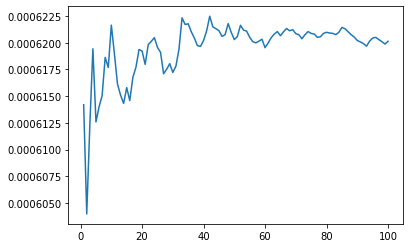

In [73]:
CC = np.zeros(N)
for i in range(N):
    for a in sum_d[i]:
        if(a!=0):
            CC[i] += 1/a
    CC[i]*=1/len(sum_d)
CC_mean = np.cumsum(CC)/(np.arange(N)+1)
plt.plot(np.arange(N)+1,CC_mean)

### Lin's centrality

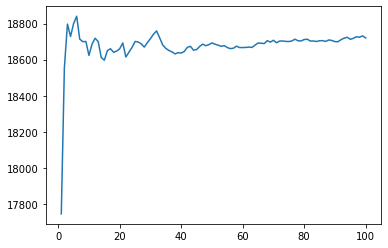

In [74]:
LC = np.zeros(N)
for i in range(N):
    for j in range(len(sum_d[i])):
        if(sum_d[i][j]!=0):
            LC[i] += cor_tab[i][j]**2/sum_d[i][j]
    LC[i]*=1/len(sum_d)
LC_mean = np.cumsum(LC)/(np.arange(N)+1)
plt.plot(np.arange(N)+1,LC_mean)

### Harmonic centrality

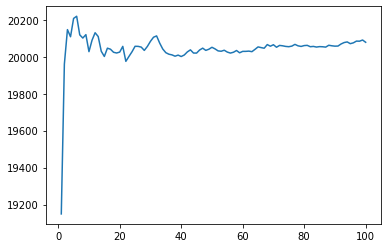

In [75]:
HC = np.zeros(N)
for i in range(N):
    HC[i] = np.sum(sum_inv_d[i])/len(sum_d)
HC_mean = np.cumsum(HC)/(np.arange(N)+1)
plt.plot(np.arange(N)+1,HC_mean)